In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from helper_functions import clean_data, model_statistics, plot_pred, extract_r_p

In [3]:
london = pd.read_csv('london_weekdays.csv')
london = clean_data(london)
london.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,570.098074,2,False,False,2.0,False,0,0,10.0,98.0,1,5.301018,1.588990,209.632578,14.571793,467.597522,8.372724,-0.16032,51.46531
1,297.984430,1,False,True,2.0,True,1,0,10.0,99.0,1,2.198946,0.379262,553.891744,38.501630,961.472137,17.215961,-0.09683,51.50343
2,336.790611,1,False,True,2.0,False,1,0,10.0,96.0,1,2.322958,0.453178,428.287849,29.770764,959.042839,17.172462,-0.10554,51.52407
3,226.722171,1,False,True,2.0,True,1,0,10.0,99.0,1,5.707825,1.723977,195.694744,13.602959,452.232472,8.097600,-0.16575,51.46292
4,256.355982,1,False,True,3.0,False,0,0,9.0,98.0,1,3.257945,0.825417,329.477068,22.902317,735.327280,13.166649,-0.12055,51.53728


In [4]:
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
x,y = extract_r_p(london)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.7063251554478525
Mean Squared Error (MSE) 	: 8394.66965338095



C:\Users\pwspang\Desktop\SC1015-AirBNB\helper_functions.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  axes.plot(y_test, y_test, 'w-', linewidth = 3, color="red")


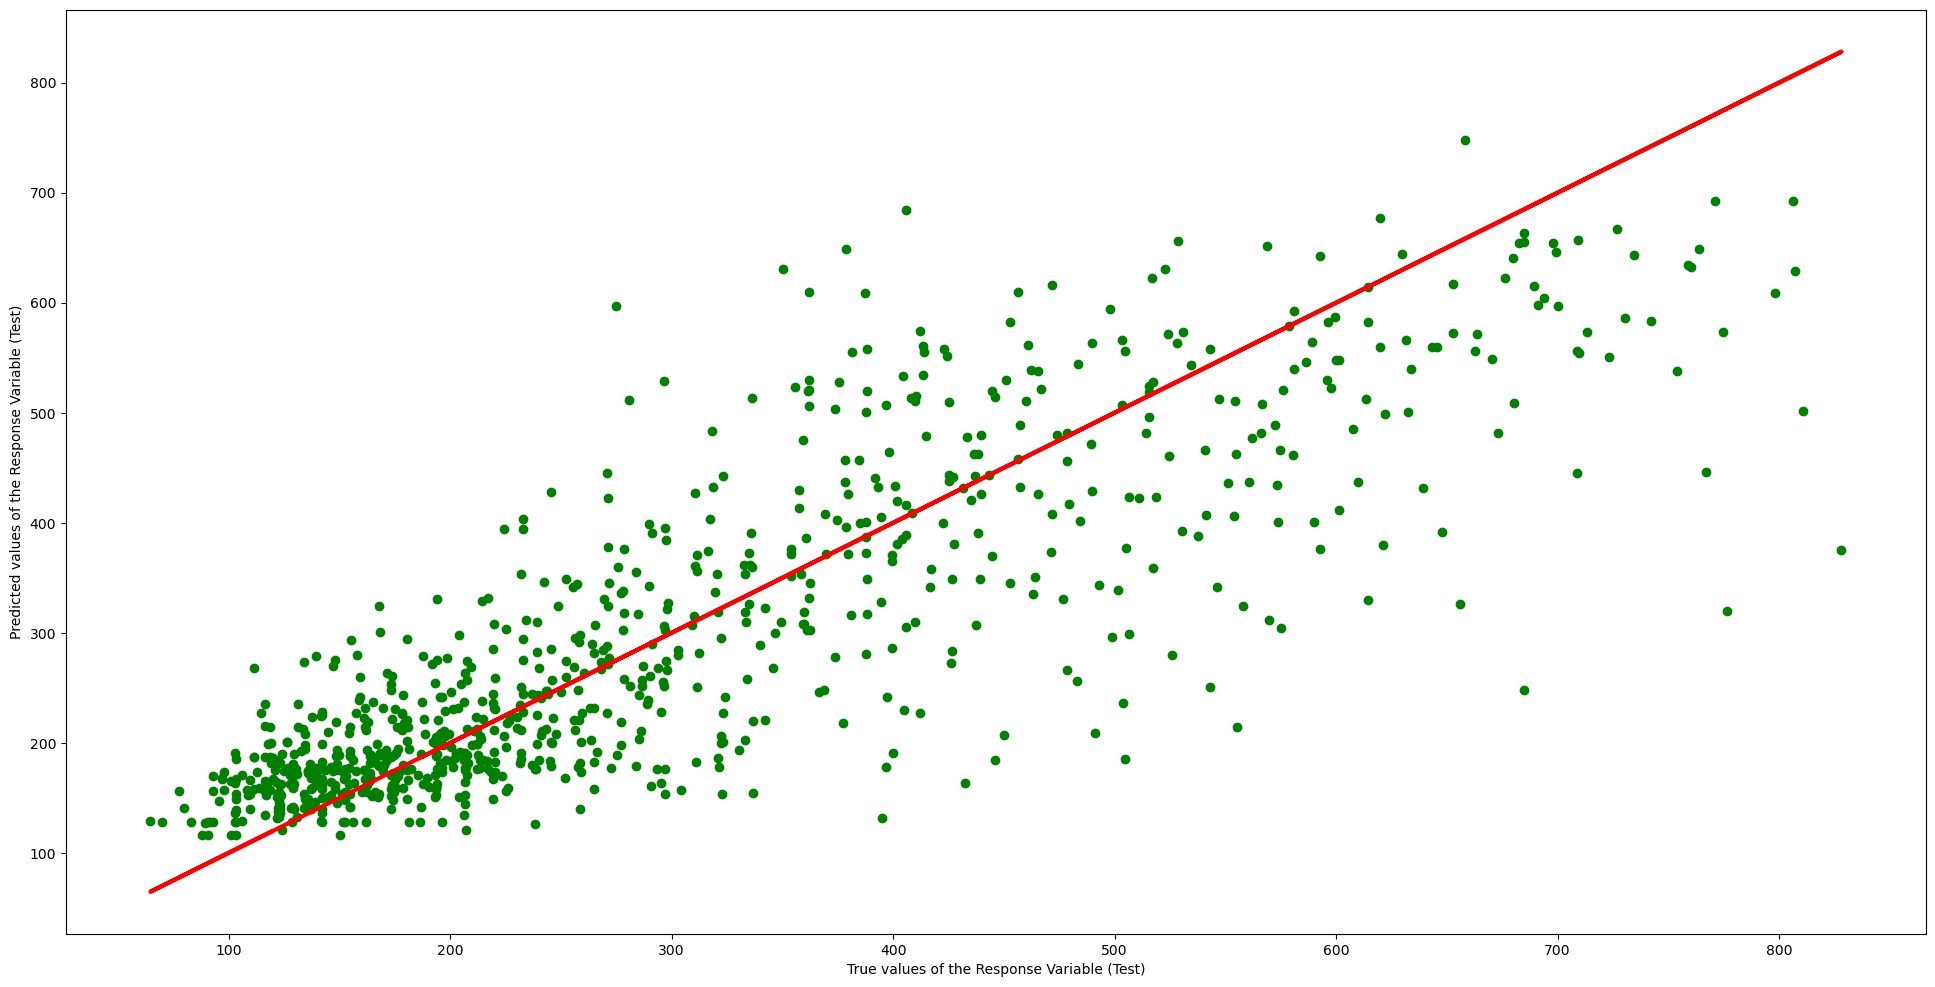

In [5]:
categorical_columns = [ 'room_type', 'biz']
hgb = HistGradientBoostingRegressor(categorical_features=categorical_columns)
#hgb = HistGradientBoostingRegressor(max_iter=100, random_state=0)
hgb.fit(x_train, y_train.values.ravel())
y_test_pred = hgb.predict(x_test)

model_statistics(hgb, x_test, y_test, y_test_pred)

plot_pred(y_test, y_test_pred)


# Tuning of Hyperparameters

From: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/


## General Paramters for Tree 
   
    1. min_samples_leaf
        Defines the minimum samples (or observations) required in a terminal node or leaf.
        Used to control over-fitting similar to min_samples_split.
        Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.
    
    2. max_depth
        The maximum depth of a tree.
        Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
        Should be tuned using CV.
  
    3. max_leaf_nodes (Not tuned, since influenced by max_depth)
        The maximum number of terminal nodes or leaves in a tree.
        Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
        If this is defined, GBM will ignore max_depth.


## Boosting Parameters 

    1. learning_rate
        This determines the impact of each tree on the final outcome (step 2.4). GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
        Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
        Lower values would require higher number of trees to model all the relations and will be computationally expensive.

## Miscellaneous parameters


    1. loss
        It refers to the loss function to be minimized in each split.
        It can have various values for classification and regression case. Generally the default values work fine. Other values should be chosen only if you understand their impact on the model.
        loss{‘squared_error’, ‘absolute_error’, ‘poisson’, ‘quantile’}
  
    2. init (Not tuning)
        This affects initialization of the output.
        This can be used if we have made another model whose outcome is to be used as the initial estimates for GBM.
  
    3. random_state (Not tuning)
        The random number seed so that same random numbers are generated every time.
        This is important for parameter tuning. If we don’t fix the random number, then we’ll have different outcomes for subsequent runs on the same parameters and it becomes difficult to compare models.
        It can potentially result in overfitting to a particular random sample selected. We can try running models for different random samples, which is computationally expensive and generally not used.
  
    4.  verbose (Not tuning)
        The type of output to be printed when the model fits. The different values can be:
            0: no output generated (default)
            1: output generated for trees in certain intervals
            >1: output generated for all trees

    5.  warm_start (Not tuning)
        This parameter has an interesting application and can help a lot if used judicially.
        Using this, we can fit additional trees on previous fits of a model. It can save a lot of time and you should explore this option for advanced applications
  
    6. presort (Not tuning)
         Select whether to presort data for faster splits.
        It makes the selection automatically by default but it can be changed if needed.



In [13]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on
param_grid = { 'min_samples_leaf' : [20, 40, 60, 80],
               'max_depth': [5,6,7,8],
               'learning_rate': [0.05, 0.1, 0.2],
               'loss' : ['squared_error', 'absolute_error', 'poisson']
               }        

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(HistGradientBoostingRegressor(categorical_features=categorical_columns),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'r2')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(x_train, y_train.values.ravel())


GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features=['room_type',
                                                                           'biz']),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'loss': ['squared_error', 'absolute_error', 'poisson'],
                         'max_depth': [5, 6, 7, 8],
                         'min_samples_leaf': [20, 40, 60, 80]},
             scoring='r2')

In [14]:
hpGrid.best_params_

{'learning_rate': 0.1,
 'loss': 'poisson',
 'max_depth': 5,
 'min_samples_leaf': 20}

In [15]:
hpGrid.best_score_

0.6920384191088751

# Determine if model is overfitting/ Underfitting

(To write more) Our model is ensembling -> boosting [prevents overfitting/underfitting]
Ensembling: Ensembling is combining predictions made by multiple separate models. The most commonly used techniques for ensembling are bagging and boosting. Bagging is a way to reduce overfitting in models by training a large number of weak learners that are set in a sequence. This helps each learner in the sequence to learn from the mistakes of the one preceding it. 

[We already use k-fold cross validation in tuning our hyperparameters]
Cross-validation: In this technique, the initial training dataset is split into several mini-train test splits. The model’s hyperparameters are then tuned using the splits. This keeps the test set unseen before finalising the model. 
